In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.optim.lr_scheduler import ExponentialLR

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from AutoAugment.autoaugment import ImageNetPolicy
# from AutoAugment.ops import *

# from autoaugment import ImageNetPolicy

from PIL import Image

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(31016, 2)

In [4]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = df[:30000]
        elif settype == "val":
            self.img_labels = df[30000:]
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                   
        label = self.img_labels.iloc[idx, 1]       
            
        return image, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        
        return file_name, image

In [6]:
# Load BEiT
model = models.densenet161(pretrained=True)

classifier = nn.Sequential(OrderedDict([
    ('fc2', nn.Linear(2208, 81)),
    ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

model.load_state_dict(torch.load("../../densenet161.pth"))

model = model.to(device);

In [7]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

In [8]:
def train_loop(trainloader, valloader, model, criterion, optimizer, scheduler = None):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        for epoch in range(2):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../densenet161.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()
            
            if scheduler:
                scheduler.step()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [9]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

# scheduler = ExponentialLR(optimizer, gamma=0.9)

In [10]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
train_transforms = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])

In [11]:
trainset = food_set(labels, img_dir, transform = train_transforms, settype = "train")
valset = food_set(labels, img_dir, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(30000, 1016)

In [12]:
testset = food_test("../data/test_set/test_set", transform = test_transforms)
testloader = DataLoader(testset, batch_size = 8)

len(testset)

7653

loss: 1.355599  [    0/30000] epoch: 1
loss: 0.606561  [ 1600/30000] epoch: 1
loss: 1.977724  [ 3200/30000] epoch: 1
loss: 1.789449  [ 4800/30000] epoch: 1
loss: 2.408054  [ 6400/30000] epoch: 1
loss: 1.705116  [ 8000/30000] epoch: 1
loss: 2.513941  [ 9600/30000] epoch: 1
loss: 1.280953  [11200/30000] epoch: 1
loss: 2.528805  [12800/30000] epoch: 1
loss: 2.150798  [14400/30000] epoch: 1
loss: 1.064911  [16000/30000] epoch: 1
loss: 1.419898  [17600/30000] epoch: 1
loss: 1.289814  [19200/30000] epoch: 1
loss: 2.149800  [20800/30000] epoch: 1
loss: 2.226601  [22400/30000] epoch: 1
loss: 1.676561  [24000/30000] epoch: 1
loss: 1.519909  [25600/30000] epoch: 1
loss: 1.270957  [27200/30000] epoch: 1
loss: 1.944550  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.810185 



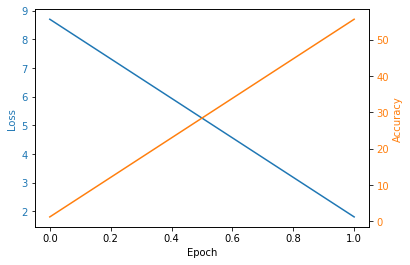

loss: 2.131558  [    0/30000] epoch: 2
loss: 2.631327  [ 1600/30000] epoch: 2
loss: 1.522233  [ 3200/30000] epoch: 2
loss: 1.816408  [ 4800/30000] epoch: 2
loss: 1.901764  [ 6400/30000] epoch: 2
loss: 1.171673  [ 8000/30000] epoch: 2
loss: 1.176619  [ 9600/30000] epoch: 2
loss: 0.892934  [11200/30000] epoch: 2
loss: 1.025284  [12800/30000] epoch: 2
loss: 2.403061  [14400/30000] epoch: 2
loss: 1.856916  [16000/30000] epoch: 2
loss: 1.149361  [17600/30000] epoch: 2
loss: 2.165148  [19200/30000] epoch: 2
loss: 2.055532  [20800/30000] epoch: 2
loss: 1.851545  [22400/30000] epoch: 2
loss: 1.069550  [24000/30000] epoch: 2
loss: 1.135839  [25600/30000] epoch: 2
loss: 0.923948  [27200/30000] epoch: 2
loss: 1.414410  [28800/30000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.796871 



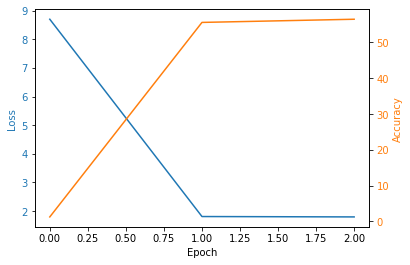

In [15]:
# stats = train_loop(trainloader, valloader, model, criterion, optimizer)

In [13]:
test_results = defaultdict(list)

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = model(X)
    
    for i, img in enumerate(file_name):
        test_results["img"].append(img)
        for rank, p in enumerate(pred.topk(5).indices[i]):
            test_results[rank + 1].append(int(p))

100%|████████████████████████████████████████| 957/957 [03:22<00:00,  4.72it/s]


In [14]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img,1,2,3,4,5
0,test_1.jpg,63,62,48,13,15
1,test_10.jpg,2,36,53,45,49
2,test_100.jpg,71,34,21,25,58
3,test_1000.jpg,15,29,2,10,1
4,test_1001.jpg,34,22,21,13,66


In [16]:
test_df.to_csv("../../ensemble_subs/densenet_ensemble.csv", index=False)